In [1]:
# ============================================================================
# CNN-LSTM Bestandsforecast-Modell
# Projekt: Vorhersage von Bestellmengen für Retail-Inventory
# ============================================================================
# Standard Libraries
from typing import Tuple, List, Dict, Any, Optional
from dataclasses import dataclass, field
import warnings
warnings.filterwarnings('ignore')

# Data Science
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## Konfiguration & Utility-Funktionen

In [2]:
# ============================================================================
# KONFIGURATION (mit @dataclass für Immutability & Type-Safety)
# ============================================================================

@dataclass(frozen=True)
class Config:
    """
    Immutable Konfiguration für das Projekt.
    
    frozen=True: Macht Instanzen unveränderlich (verhindert Bugs)
    """
    # Datenpfade
    data_path: str = "/Users/mag/Library/Mobile Documents/com~apple~CloudDocs/Studium/7. Semester/Machine und Deep Learning/Bestands_Forecast/retail_store_inventory.csv"
    
    # Zeitreihen-Parameter
    seq_length: int = 30
    target_col: str = "Units Sold"
    
    # Train/Test Split
    test_size: float = 0.2
    random_state: int = 42
    
    # Modell-Architektur (VEREINFACHT!)
    conv_filters: Tuple[int, int] = (64, 32)
    lstm_units: Tuple[int,] = (64,)  # NUR 1 LSTM Layer!
    dense_units: Tuple[int, int] = (32, 16)
    
    # Training
    batch_size: int = 64
    epochs: int = 50
    learning_rate: float = 0.001
    weight_decay: float = 0.0  # DEAKTIVIERT (verwenden L2 stattdessen)
    
    # Regularisierung (REDUZIERT!)
    dropout_rate: float = 0.1  # War 0.2, jetzt 0.1
    l2_reg: float = 0.0001  # War 0.001, jetzt 0.0001
    early_stopping_patience: int = 10  # War 5, jetzt 10
    lr_reduce_patience: int = 5  # War 3, jetzt 5
    lr_reduce_factor: float = 0.5
    
    # Feature Engineering
    groupby_cols: Tuple[str, str] = ("Store_ID_Encoded", "Product_ID_Encoded")
    id_cols: Tuple[str, ...] = ("Store_ID_Encoded", "Product_ID_Encoded")
    exclude_from_scaling: Tuple[str, ...] = field(default_factory=lambda: ("Date",))


@dataclass
class ProcessedData:
    """Container für vorverarbeitete Daten (verhindert lose Variablen)."""
    X_train: np.ndarray
    y_train: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    feature_cols: List[str]
    scaler_features: StandardScaler
    scaler_target: StandardScaler
    mappings: Dict[str, Dict]


@dataclass
class TrainingResults:
    """Container für Training-Ergebnisse."""
    model: tf.keras.Model
    history: tf.keras.callbacks.History
    test_metrics: Dict[str, float]
    predictions: np.ndarray


# Instanziieren
config = Config()
print("✓ Konfiguration geladen (immutable dataclass)")
print("⚠️  Regularisierung REDUZIERT für besseres Lernen:")

✓ Konfiguration geladen (immutable dataclass)
⚠️  Regularisierung REDUZIERT für besseres Lernen:


In [3]:
# ============================================================================
# DATEN-LOADING & EXPLORATION
# ============================================================================

def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """
    Lädt CSV-Datei und führt grundlegende Exploration durch.
    
    Args:
        file_path: Pfad zur CSV-Datei
        
    Returns:
        DataFrame mit geladenen Daten
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print("=" * 70)
    print("📊 DATEN-ÜBERSICHT")
    print("=" * 70)
    print(f"Shape: {df.shape} (Zeilen, Spalten)")
    print(f"Date Range: {df['Date'].min()} bis {df['Date'].max()}")
    print(f"Total Tage: {(df['Date'].max() - df['Date'].min()).days + 1}")
    
    print("\n" + "=" * 70)
    print("📋 DATENTYPEN & FEHLENDE WERTE")
    print("=" * 70)
    print(df.info())
    print(f"\nFehlende Werte: {df.isnull().sum().sum()} (Gesamt)")
    
    print("\n" + "=" * 70)
    print("📈 STATISTISCHE ZUSAMMENFASSUNG")
    print("=" * 70)
    print(df.describe().round(2))
    
    return df

In [4]:
# Laden und explorieren
df = load_and_explore_data(config.data_path)

📊 DATEN-ÜBERSICHT
Shape: (73100, 15) (Zeilen, Spalten)
Date Range: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
Total Tage: 731

📋 DATENTYPEN & FEHLENDE WERTE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  

## Feature Engineering: Encoding, Split, Skalierung

In [5]:
# ============================================================================
# SEQUENZEN-ERSTELLUNG
# ============================================================================

def create_sequences_from_group(
    group: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen aus einer einzigen Store-Product-Gruppe.
    
    Logik:
    - Input: seq_length aufeinanderfolgende Tage (Features)
    - Output: Nächster Tag (Target)
    
    Args:
        group: DataFrame für eine Store-Product-Kombination
        feature_cols: Feature-Spalten
        target_col: Zielgröße
        seq_length: Länge der Sequenzen (z.B. 30 Tage)
        
    Returns:
        Tupel (X, y) mit shapes ((n_samples, seq_length, n_features), (n_samples,))
    """
    data_features = group[feature_cols].values
    data_target = group[target_col].values
    
    X_list, y_list = [], []
    
    # Sliding Window über die Gruppe
    for i in range(len(group) - seq_length):
        x_seq = data_features[i:i + seq_length]
        y_t = data_target[i + seq_length]
        X_list.append(x_seq)
        y_list.append(y_t)
    
    if not X_list:
        return np.empty((0, seq_length, len(feature_cols))), np.empty((0,))
    
    return np.array(X_list), np.array(y_list)


def create_sequences_dataset(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int,
    groupby_cols: List[str] = ["Store_ID_Encoded", "Product_ID_Encoded"]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen für ALLE Store-Product-Gruppen.
    
    Grund der Gruppierung: Verhindert Leakage über Stores/Produkte hinweg.
    
    Args:
        df: Skalierter DataFrame
        feature_cols: Feature-Spalten
        target_col: Zielgröße
        seq_length: Sequenzlänge (z.B. 30 Tage)
        groupby_cols: Spalten zum Gruppieren (Default: Store + Product)
        
    Returns:
        Tupel (X, y) mit shapes ((total_samples, seq_length, n_features), (total_samples,))
    """
    X_all, y_all = [], []
    
    grouped = df.groupby(groupby_cols)
    n_groups = len(grouped)
    
    for (store_id, prod_id), group in grouped:
        X_group, y_group = create_sequences_from_group(group, feature_cols, target_col, seq_length)
        if len(X_group) > 0:
            X_all.append(X_group)
            y_all.append(y_group)
    
    if not X_all:
        raise ValueError(f"❌ Keine Sequenzen erzeugt! SEQ_LENGTH={seq_length} möglicherweise zu groß.")
    
    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    
    print(f"✓ Sequenzen erstellt aus {n_groups} Store-Product-Gruppen")
    print(f"  X shape: {X.shape} (Samples, TimeSteps, Features)")
    print(f"  y shape: {y.shape}")
    
    return X, y

In [6]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def encode_categorical_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Dict]]:
    """
    Konvertiert kategorische Variablen zu numerischen Features.
    
    Strategie:
    - Store ID & Product ID: Label-Encoding (für zukünftige Embeddings)
    - Kategorien: One-Hot-Encoding (semantische Bedeutung)
    
    Args:
        df: Input DataFrame
        
    Returns:
        Tupel (encoded_df, mapping_dict)
    """
    df = df.copy()
    mappings = {}
    
    # Label-Encoding für Store und Product
    for col in ["Store ID", "Product ID"]:
        unique_vals = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        encoded_col_name = col.replace(" ", "_") + "_Encoded"
        df[encoded_col_name] = df[col].map(mapping)
        mappings[col] = mapping
    
    # One-Hot für kategorische Features
    cat_cols = ["Category", "Region", "Weather Condition", "Seasonality"]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    
    # Aufräumen: alte Spalten entfernen, Date behalten
    df = df.drop(columns=["Store ID", "Product ID"], errors='ignore')
    
    print("✓ Encoding abgeschlossen!")
    print(f"  Features nach Encoding: {df.shape[1]} Spalten")
    
    return df, mappings


def train_test_time_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Zeitbasierter Train/Test Split (verhindert Data Leakage).
    
    Strategie: Die letzten X% sind Test (Zukunft), erste (1-X)% sind Train (Vergangenheit).
    
    Args:
        df: Input DataFrame (muss 'Date' Spalte haben)
        test_size: Anteil für Test (z.B. 0.2 = 20%)
        
    Returns:
        Tupel (df_train, df_test)
    """
    df = df.sort_values("Date").reset_index(drop=True)
    n_test = int(len(df) * test_size)
    
    df_train = df.iloc[:-n_test].copy()
    df_test = df.iloc[-n_test:].copy()
    
    print("✓ Train/Test Split (zeitbasiert) durchgeführt!")
    print(f"  Train: {len(df_train)} Zeilen ({100*(1-test_size):.0f}%)")
    print(f"  Test:  {len(df_test)} Zeilen ({100*test_size:.0f}%)")
    
    return df_train, df_test


def scale_data(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    feature_cols: List[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler]:
    """
    Standardisiert Features und Target mit StandardScaler.
    
    Wichtig: Scaler wird auf Training-Daten angepasst, dann auf Test angewendet!
    
    Args:
        df_train: Trainings-DataFrame
        df_test: Test-DataFrame
        feature_cols: Liste der Feature-Spalten
        target_col: Name der Zielgröße
        
    Returns:
        Tupel (df_train_scaled, df_test_scaled, scaler_features, scaler_target)
    """
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    
    # Features: fit auf Train, transform auf beide
    df_train_scaled[feature_cols] = scaler_features.fit_transform(df_train[feature_cols])
    df_test_scaled[feature_cols] = scaler_features.transform(df_test[feature_cols])
    
    # Target: fit auf Train, transform auf beide
    df_train_scaled[[target_col]] = scaler_target.fit_transform(df_train[[target_col]])
    df_test_scaled[[target_col]] = scaler_target.transform(df_test[[target_col]])
    
    print("✓ Skalierung (StandardScaler) durchgeführt!")
    print(f"  {len(feature_cols)} Features + 1 Target skaliert")
    
    return df_train_scaled, df_test_scaled, scaler_features, scaler_target

In [7]:
# ============================================================================
# FEATURE ENGINEERING DURCHFÜHREN
# ============================================================================

def prepare_data_pipeline(df: pd.DataFrame, config: Config) -> ProcessedData:
    """
    Komplette Data-Preparation-Pipeline (Single Responsibility).
    
    Führt alle Schritte aus:
    1. Encoding kategorischer Features
    2. Train/Test Split (zeitbasiert)
    3. Feature-Identifikation
    4. Skalierung
    5. Sequenzen-Erstellung
    
    Args:
        df: Rohdaten DataFrame
        config: Konfiguration
        
    Returns:
        ProcessedData Container mit allen vorverarbeiteten Daten
    """
    # 1. Encoding
    df_encoded, mappings = encode_categorical_features(df)
    
    # 2. Split
    df_train, df_test = train_test_time_split(df_encoded, test_size=config.test_size)
    
    # 3. Feature-Identifikation
    exclude_cols = [config.target_col, *config.exclude_from_scaling, *config.id_cols]
    feature_cols = [col for col in df_train.columns if col not in exclude_cols]
    print(f"✓ {len(feature_cols)} Features identifiziert (ohne IDs)")
    
    # 4. Skalierung
    df_train_scaled, df_test_scaled, scaler_feat, scaler_tgt = scale_data(
        df_train, df_test, feature_cols, config.target_col
    )
    
    # 5. Sequenzen
    print("\n🔄 Erstelle Sequenzen...")
    X_train, y_train = create_sequences_dataset(
        df_train_scaled, feature_cols, config.target_col, 
        config.seq_length, list(config.groupby_cols)
    )
    X_test, y_test = create_sequences_dataset(
        df_test_scaled, feature_cols, config.target_col, 
        config.seq_length, list(config.groupby_cols)
    )
    
    return ProcessedData(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        feature_cols=feature_cols,
        scaler_features=scaler_feat,
        scaler_target=scaler_tgt,
        mappings=mappings
    )


# Pipeline ausführen
print("🔄 Starte Data Preparation Pipeline...\n")
data = prepare_data_pipeline(df, config)
print(f"\n✅ Pipeline abgeschlossen!")
print(f"   Train: {data.X_train.shape}, Test: {data.X_test.shape}")

🔄 Starte Data Preparation Pipeline...

✓ Encoding abgeschlossen!
  Features nach Encoding: 28 Spalten
✓ Train/Test Split (zeitbasiert) durchgeführt!
  Train: 58480 Zeilen (80%)
  Test:  14620 Zeilen (20%)
✓ 24 Features identifiziert (ohne IDs)
✓ Skalierung (StandardScaler) durchgeführt!
  24 Features + 1 Target skaliert

🔄 Erstelle Sequenzen...
✓ Train/Test Split (zeitbasiert) durchgeführt!
  Train: 58480 Zeilen (80%)
  Test:  14620 Zeilen (20%)
✓ 24 Features identifiziert (ohne IDs)
✓ Skalierung (StandardScaler) durchgeführt!
  24 Features + 1 Target skaliert

🔄 Erstelle Sequenzen...
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (55480, 30, 24) (Samples, TimeSteps, Features)
  y shape: (55480,)
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (11620, 30, 24) (Samples, TimeSteps, Features)
  y shape: (11620,)

✅ Pipeline abgeschlossen!
   Train: (55480, 30, 24), Test: (11620, 30, 24)
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (55480, 30, 

## Modellaufbau

In [8]:
# ============================================================================
# MODELLAUFBAU (Best-Practice Architektur)
# ============================================================================

def build_cnn_lstm_model(
    seq_length: int,
    num_features: int,
    config: Config
) -> tf.keras.Model:
    """
    Baut CNN-BiLSTM Architektur mit Best-Practice Patterns.
    
    VERBESSERUNGEN:
    ✓ Bidirektionale LSTMs 
    ✓ Layer Normalization
    ✓ L2 Regularisierung
    ✓ AdamW Optimizer
    
    Args:
        seq_length: Zeitschritte (z.B. 30)
        num_features: Features pro Zeitschritt (z.B. 24)
        config: Konfigurationsobjekt
        
    Returns:
        Kompiliertes TensorFlow Modell
    """
    inputs = layers.Input(shape=(seq_length, num_features), name="time_series_input")
    
    # CNN-Block
    x = inputs
    for i, filters in enumerate(config.conv_filters, 1):
        x = layers.Conv1D(
            filters=filters, 
            kernel_size=3, 
            padding="same", 
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
            name=f"conv1d_{i}"
        )(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        if i == len(config.conv_filters):
            x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(config.dropout_rate)(x)
    
    # BiLSTM-Block (KEIN internes Dropout mehr!)
    for i, units in enumerate(config.lstm_units, 1):
        return_seq = (i < len(config.lstm_units))
        x = layers.Bidirectional(
            layers.LSTM(units, return_sequences=return_seq),  # KEIN dropout= Parameter!
            name=f"bilstm_{i}"
        )(x)
        if not return_seq:
            x = layers.Dropout(config.dropout_rate)(x)  # NUR externes Dropout
    
    # Dense-Block
    for i, units in enumerate(config.dense_units, 1):
        x = layers.Dense(units, activation="relu", 
                        kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg))(x)
        if i < len(config.dense_units):
            x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dropout(config.dropout_rate * (0.75 if i == len(config.dense_units) else 1))(x)
    
    # Output
    outputs = layers.Dense(1, name="units_sold_prediction")(x)
    
    # Kompilieren
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_BiLSTM_Forecast")
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay
        ),
        loss="mse",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name="mae"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )
    
    return model


# Modell bauen
print("\n🏗️  Baue CNN-BiLSTM Modell...\n")
num_features = data.X_train.shape[2]
model = build_cnn_lstm_model(config.seq_length, num_features, config)

print("\n✓ Modell-Architektur:")
model.summary()



🏗️  Baue CNN-BiLSTM Modell...


✓ Modell-Architektur:


Model: "CNN_BiLSTM_Forecast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_series_input (InputLayer)  │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 30, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ units_sold_prediction (Dense)   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,441 (255.63 KB)

 Trainable params: 65,441 (255.63 KB)

 Non-trainable params: 0 (0.00 B)

## Training & Evaluation

In [9]:
# ============================================================================
# TRAINING & EVALUATION PIPELINE
# ============================================================================

def create_callbacks(config: Config) -> List[tf.keras.callbacks.Callback]:
    """Factory für Training-Callbacks."""
    return [
        EarlyStopping(
            monitor="val_loss",
            patience=config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=config.lr_reduce_factor,
            patience=config.lr_reduce_patience,
            min_lr=1e-6,
            verbose=1
        )
    ]


def train_and_evaluate(
    model: tf.keras.Model,
    data: ProcessedData,
    config: Config
) -> TrainingResults:
    """
    Komplette Training & Evaluation Pipeline.
    
    Args:
        model: Untrainiertes Modell
        data: Vorverarbeitete Daten
        config: Konfiguration
        
    Returns:
        TrainingResults mit Modell, History, Metriken, Predictions
    """
    print("🚀 Starte Training...")
    print(f"  Train: {len(data.X_train)}, Test: {len(data.X_test)}")
    print(f"  Batch Size: {config.batch_size}, Max Epochs: {config.epochs}\n")
    
    # Training
    history = model.fit(
        data.X_train, data.y_train,
        validation_data=(data.X_test, data.y_test),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=create_callbacks(config),
        verbose=1
    )
    
    # Evaluation
    print("\n" + "=" * 70)
    print("📊 EVALUATIONS-ERGEBNISSE")
    print("=" * 70)
    test_loss, test_mae, test_mape, test_rmse = model.evaluate(
        data.X_test, data.y_test, verbose=0
    )
    
    test_metrics = {
        "loss": test_loss,
        "mae": test_mae,
        "mape": test_mape,
        "rmse": test_rmse
    }
    
    print(f"Loss (MSE): {test_loss:.6f}")
    print(f"MAE:        {test_mae:.6f}")
    print(f"MAPE:       {test_mape:.4f}%")
    print(f"RMSE:       {test_rmse:.6f}")
    
    # Predictions
    predictions = model.predict(data.X_test, verbose=0)
    
    return TrainingResults(
        model=model,
        history=history,
        test_metrics=test_metrics,
        predictions=predictions
    )


# Training ausführen
results = train_and_evaluate(model, data, config)

🚀 Starte Training...
  Train: 55480, Test: 11620
  Batch Size: 64, Max Epochs: 50

Epoch 1/50
Epoch 1/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.0242 - mae: 0.8207 - mape: 107.0129 - rmse: 1.0046 - val_loss: 0.9975 - val_mae: 0.8153 - val_mape: 101.9311 - val_rmse: 0.9915 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.0242 - mae: 0.8207 - mape: 107.0129 - rmse: 1.0046 - val_loss: 0.9975 - val_mae: 0.8153 - val_mape: 101.9311 - val_rmse: 0.9915 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.0168 - mae: 0.8186 - mape: 100.8036 - rmse: 1.0015 - val_loss: 0.9960 - val_mae: 0.8149 - val_mape: 101.4797 - val_rmse: 0.9915 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.0168 - mae: 0.8186 - mape: 100.8036 - rmse: 1.0015 - val_loss: 0.9960 - val_mae: 0.8149 - val_mape: 101.4797 - val_rmse: 0.9915 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11


📈 Erstelle Visualisierungen...


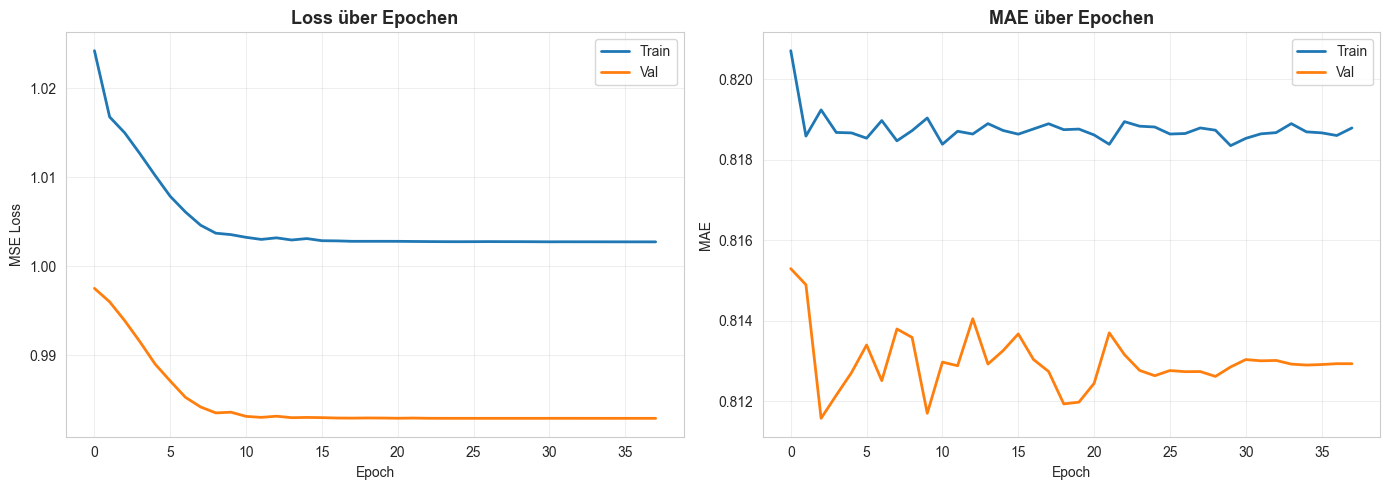

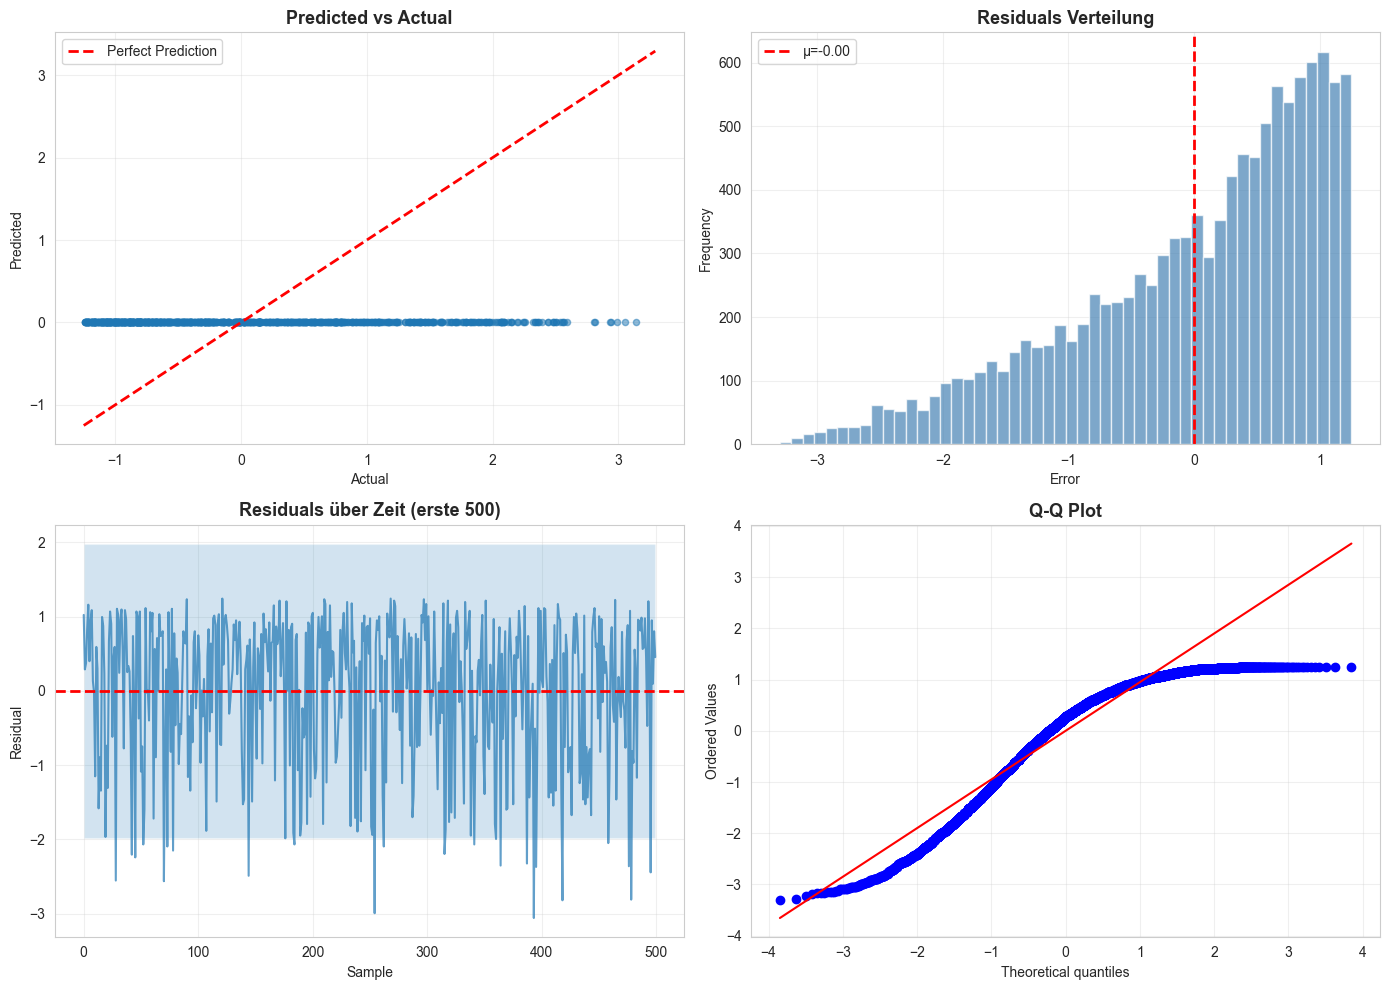

In [10]:
# ============================================================================
# VISUALISIERUNGEN
# ============================================================================

def plot_training_history(history: tf.keras.callbacks.History) -> None:
    """Visualisiert Training-Verlauf (Loss und MAE)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[0].set_title('Loss über Epochen', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Val', linewidth=2)
    axes[1].set_title('MAE über Epochen', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions_analysis(
    y_test: np.ndarray, 
    predictions: np.ndarray,
    sample_size: int = 1000
) -> None:
    """Visualisiert Vorhersagen vs Actual + Residuals."""
    from scipy import stats
    
    residuals = predictions.flatten() - y_test
    sample_size = min(sample_size, len(y_test))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Predicted vs Actual
    axes[0, 0].scatter(y_test[:sample_size], predictions[:sample_size], alpha=0.5, s=20)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                    'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_title('Predicted vs Actual', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Actual')
    axes[0, 0].set_ylabel('Predicted')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals Histogram
    axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='steelblue')
    axes[0, 1].axvline(np.mean(residuals), color='red', linestyle='--', 
                       linewidth=2, label=f'μ={np.mean(residuals):.2f}')
    axes[0, 1].set_title('Residuals Verteilung', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Residuals über Zeit
    axes[1, 0].plot(residuals[:500], alpha=0.7)
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].fill_between(range(500), -2*np.std(residuals), 
                            2*np.std(residuals), alpha=0.2)
    axes[1, 0].set_title('Residuals über Zeit (erste 500)', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Sample')
    axes[1, 0].set_ylabel('Residual')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Visualisierungen erstellen
print("\n📈 Erstelle Visualisierungen...")
plot_training_history(results.history)
plot_predictions_analysis(data.y_test, results.predictions)

In [11]:
# ============================================================================
# PROJEKT-ZUSAMMENFASSUNG
# ============================================================================

def print_summary(config: Config, results: TrainingResults) -> None:
    """Druckt Projekt-Zusammenfassung."""
    n_epochs = len(results.history.history['loss'])
    best_val_loss = min(results.history.history['val_loss'])
    
    print("\n" + "=" * 70)
    print("🎉 PROJEKT-ZUSAMMENFASSUNG")
    print("=" * 70)
    
    print("\n📋 KONFIGURATION:")
    print(f"  • Sequenzlänge: {config.seq_length} Tage")
    print(f"  • Split: {(1-config.test_size)*100:.0f}% Train / {config.test_size*100:.0f}% Test")
    print(f"  • Batch Size: {config.batch_size}, LR: {config.learning_rate}")
    
    print("\n🏗️  ARCHITEKTUR:")
    print(f"  • Conv: {config.conv_filters}, BiLSTM: {config.lstm_units}, Dense: {config.dense_units}")
    print(f"  • Regularisierung: Dropout ({config.dropout_rate}), L2 ({config.l2_reg}), Weight Decay ({config.weight_decay})")
    
    print("\n📊 ERGEBNISSE:")
    print(f"  • Epochen: {n_epochs}, Beste Val Loss: {best_val_loss:.6f}")
    print(f"  • Test MSE: {results.test_metrics['loss']:.6f}")
    print(f"  • Test MAE: {results.test_metrics['mae']:.6f}")
    print(f"  • Test MAPE: {results.test_metrics['mape']:.4f}%")
    print(f"  • Test RMSE: {results.test_metrics['rmse']:.6f}")
    
    print("\n" + "=" * 70)


print_summary(config, results)


🎉 PROJEKT-ZUSAMMENFASSUNG

📋 KONFIGURATION:
  • Sequenzlänge: 30 Tage
  • Split: 80% Train / 20% Test
  • Batch Size: 64, LR: 0.001

🏗️  ARCHITEKTUR:
  • Conv: (64, 32), BiLSTM: (64,), Dense: (32, 16)
  • Regularisierung: Dropout (0.1), L2 (0.0001), Weight Decay (0.0)

📊 ERGEBNISSE:
  • Epochen: 38, Beste Val Loss: 0.982899
  • Test MSE: 0.982900
  • Test MAE: 0.812738
  • Test MAPE: 99.9706%
  • Test RMSE: 0.991413

